# Macroevolutionary models, parameter estimation and model comparison

In [1]:
library(DDD)
library(ape)
library(ggplot2)
library(ggtree)
library(gridExtra)
library(repr)

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

ggtree v3.0.4  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36. doi:10.1111/2041-210X.12628




Attaching package: ‘ggtree’


The following object is masked from ‘package:ape’:

    rotate




## Exercise 1
Use the function `dd_sim` in the package DDD to simulate a diversity-dependent birth-death process. Choose λ0 = 3, µ = 0.1, and K = 40.
Plot the tree. Do this for various tree ages. What do you observe?

In [2]:
param <- c(3, 0.1, 40)
ages <- c(50, 100, 200, 500, 1000)

sim_out <- lapply(ages, DDD::dd_sim, pars=param)

for (i in 1:length(sim_out)){
    sim_out[[i]][["age"]] <- ages[i]
}

In [3]:
plot_tree <- function(x){
    p <- ggtree(x[['tes']]) + 
        ggtitle(paste("Age = ", x[['age']])) + 
        geom_treescale(x=0.0, y=35, width=10, fontsize=7, linesize = 2) +
        theme_tree2(text = element_text(size = 20))
    return(p)
}

plots <- lapply(sim_out, plot_tree)

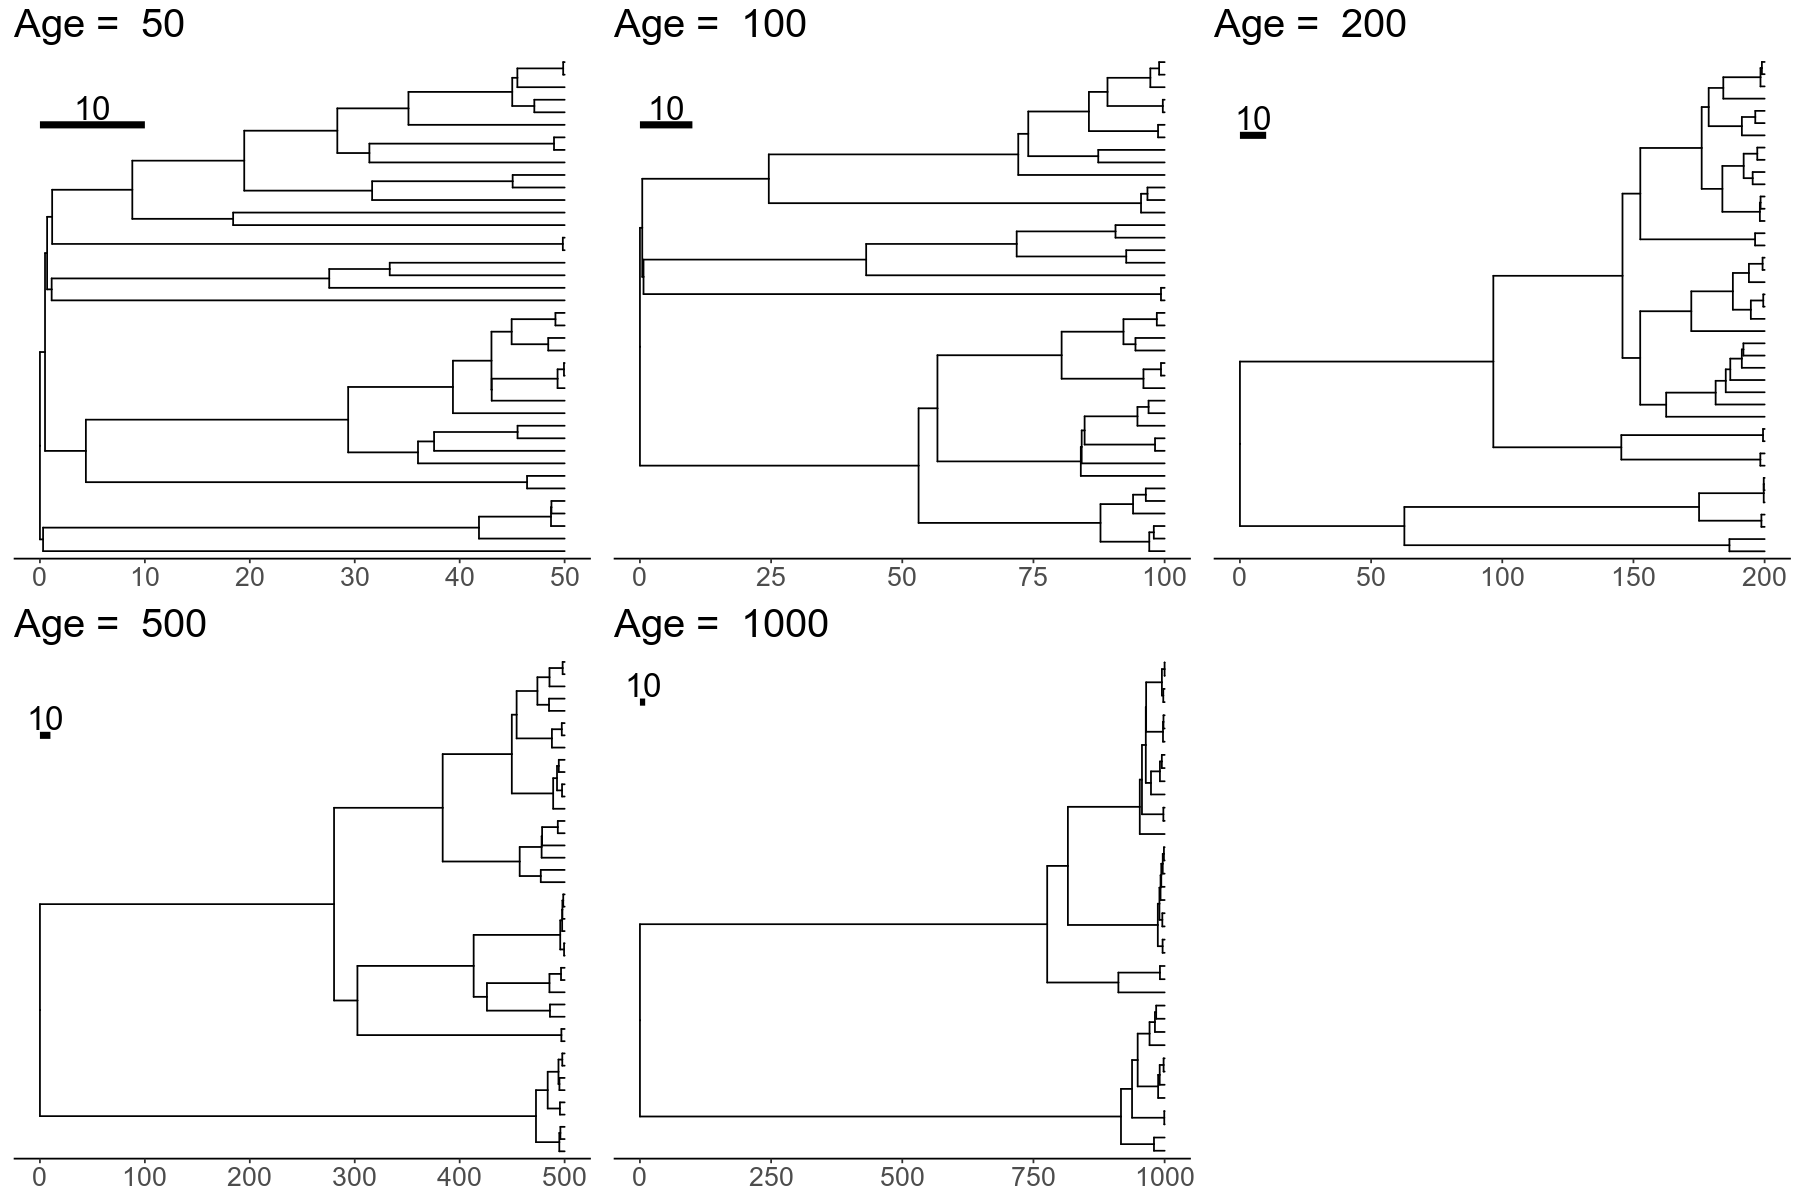

In [4]:
fig(15,10)
do.call("grid.arrange", c(plots, ncol=3, nrow=2))

## Exercise 2
Use function `ltt.plot` in package ape to plot the LTT plot for the simulations you did with `dd_sim`. Repeat this for various extinction
rates. What do you observe?

In [5]:
plot_ltt <- function(x, par){
    ltt_data <- as.data.frame(ape::ltt.plot.coords(x[["tes"]])) # just look at extant species, extincted species are excluded
    p <- ggplot(ltt_data, aes(x=time, y=N)) + geom_line() +
        ggtitle(paste(par, " = ", x[[par]])) +
        theme_bw(base_size = 20)
    return(p)
}

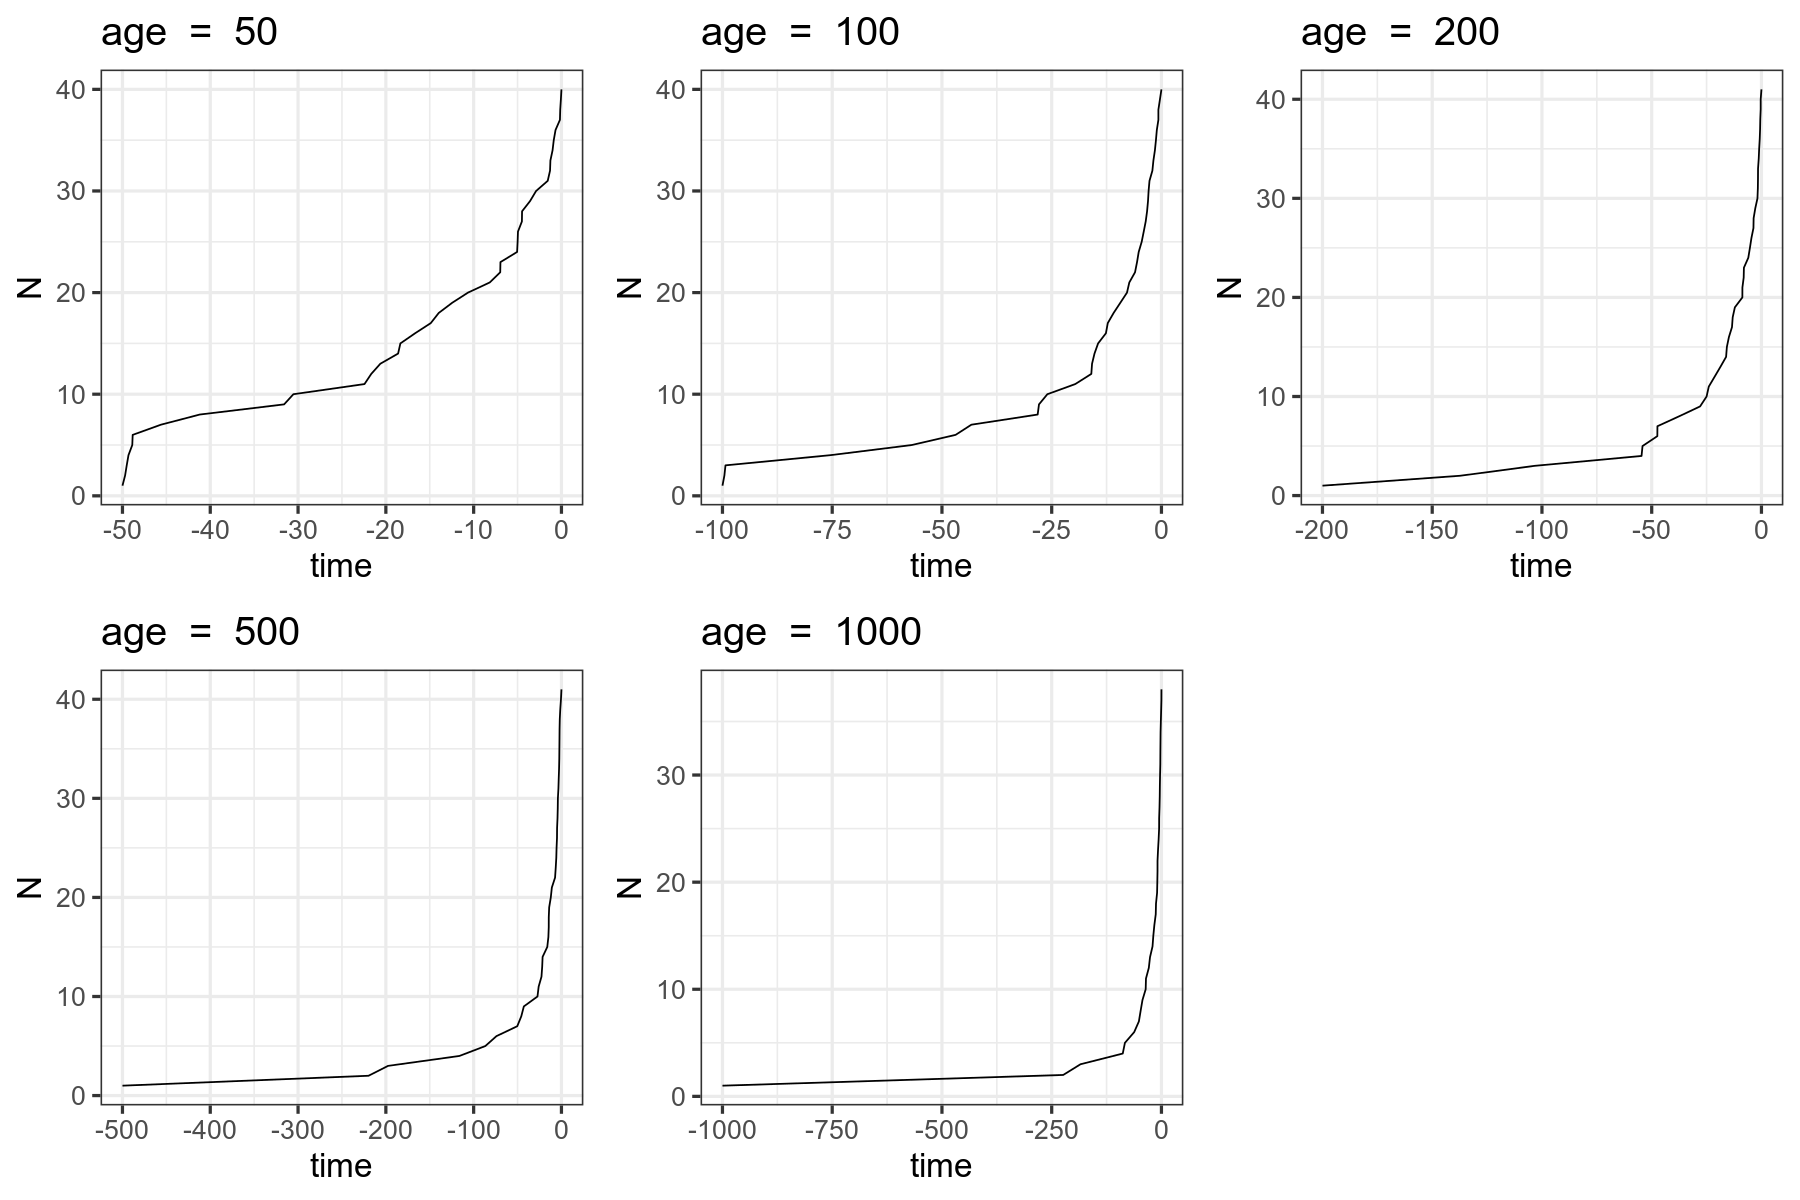

In [6]:
# explore for different ages, use the previous simulation outputs
ltt_plots <- lapply(sim_out, plot_ltt, par="age")

do.call("grid.arrange", c(ltt_plots, ncol=3, nrow=2))

In [12]:
# explore different extinction rate
lambda <- 3.0
K <- 40
mu <- c(0.05, 0.1, 0.2, 0.5, 1.2, 2.0)
param_list <- lapply(mu, function(x) c(lambda, x, K))
str(param_list)

List of 6
 $ : num [1:3] 3 0.05 40
 $ : num [1:3] 3 0.1 40
 $ : num [1:3] 3 0.2 40
 $ : num [1:3] 3 0.5 40
 $ : num [1:3] 3 1.2 40
 $ : num [1:3] 3 2 40


In [14]:
sim_out <- lapply(param_list, DDD::dd_sim, age=50) #let's just fix age at 50

for (i in 1:length(sim_out)){
    sim_out[[i]][["mu"]] <- mu[i]
}

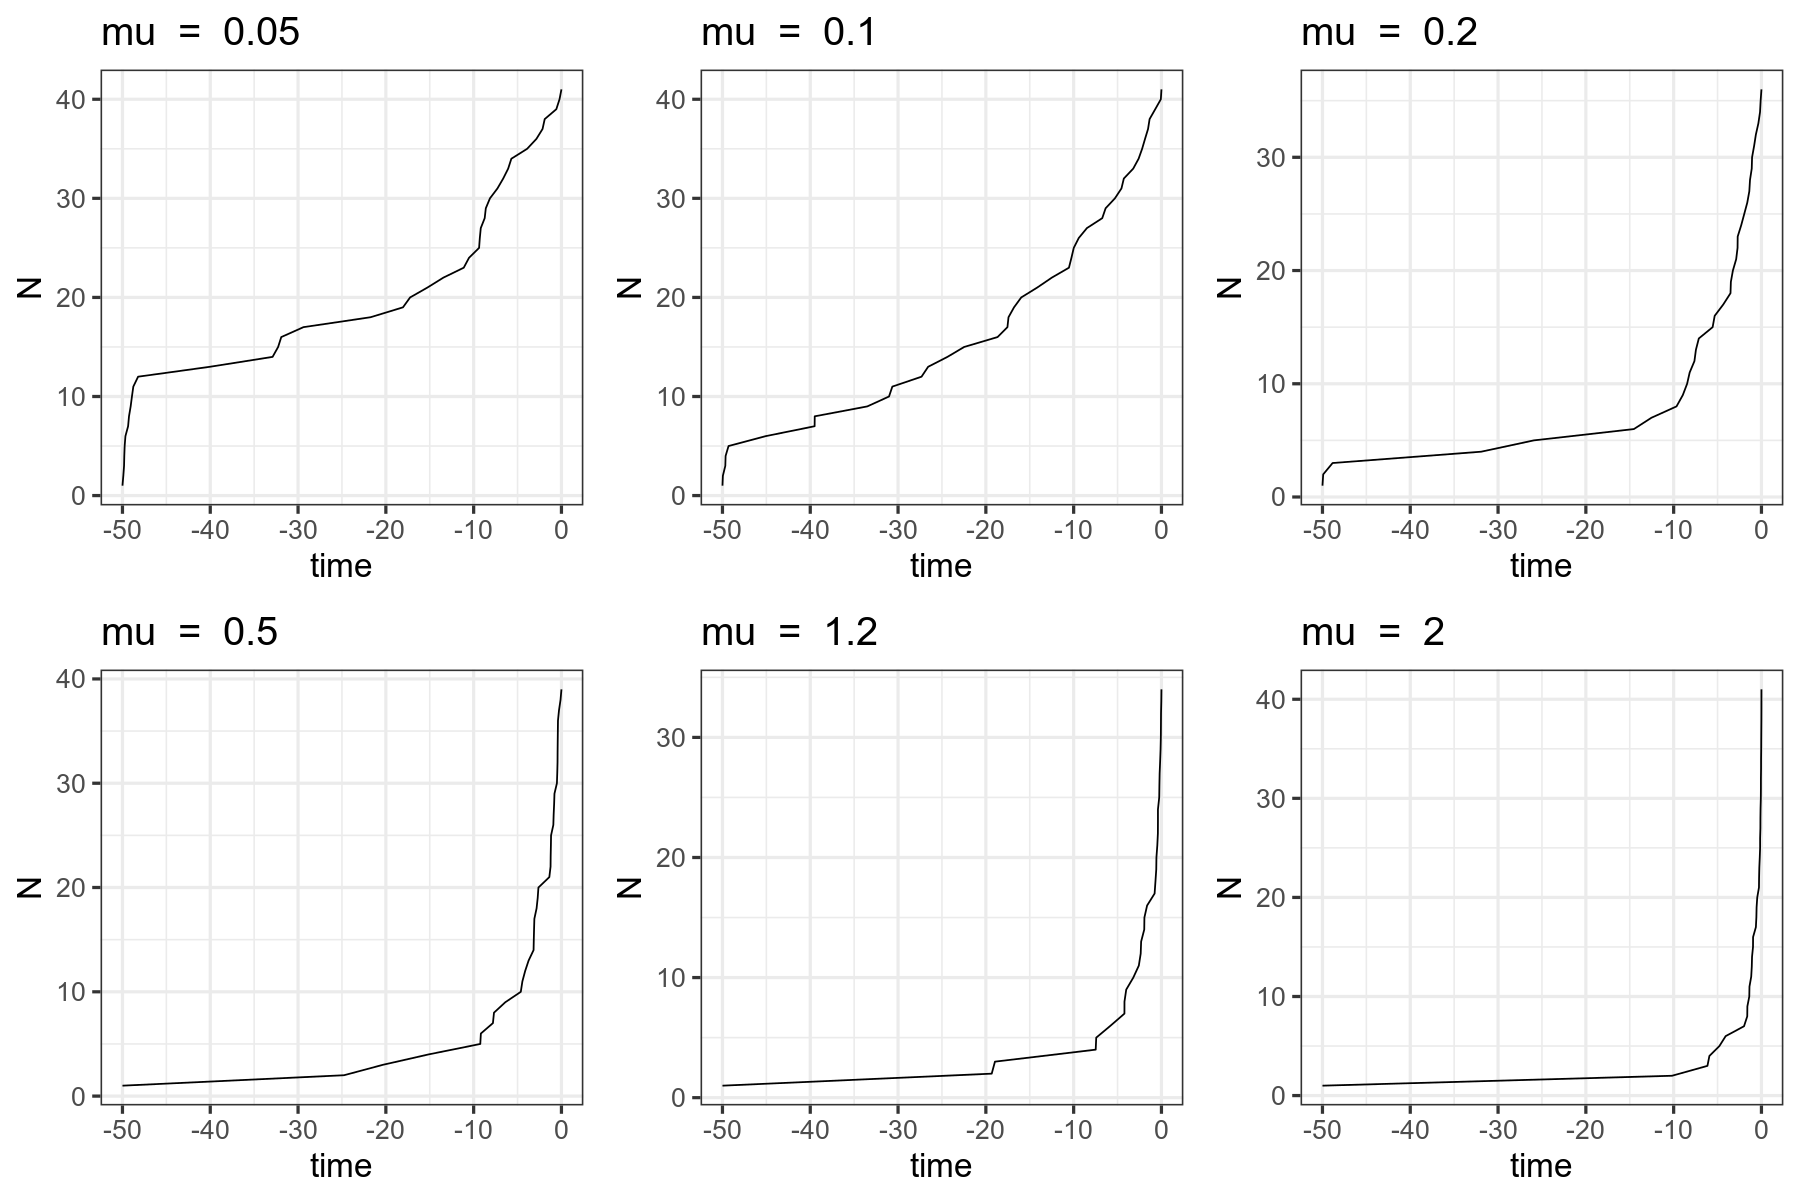

In [15]:
# explore different extinction rate
ltt_plots <- lapply(sim_out, plot_ltt, par="mu")

do.call("grid.arrange", c(ltt_plots, ncol=3, nrow=2))

## Exercise 3
Simulate a tree with dd_sim for λ0 = 3, µ = 0.1, and K = 40 and a crown age of 15, and estimate the parameters using `dd_ML`. Repeat this for various other values of K. How well do your parameter estimates match the parameter values used to simulate? Hint: Use `branching.times` from the package ape to obtain branching times.

In [2]:
# explore different carrying capacity K
lambda <- 3.0
K <- c(20, 40, 60)
mu <- 0.1
param_list <- lapply(K, function(x) c(lambda, mu, x))
str(param_list)

List of 3
 $ : num [1:3] 3 0.1 20
 $ : num [1:3] 3 0.1 40
 $ : num [1:3] 3 0.1 60


In [3]:
sim_out <- lapply(param_list, DDD::dd_sim, age=15) 

for (i in 1:length(sim_out)){
    sim_out[[i]][["K"]] <- K[i]
}

In [4]:
brts_list <- lapply(sim_out, function(x) ape::branching.times(x[["tes"]]))

data_ML <- data.frame()
for (i in 1:length(K)){
    opt_out <- DDD::dd_ML(brts_list[[i]], initparsopt = param_list[[i]])
    data <- cbind(data.frame(K_sim=c(K[i])), opt_out)
    data_ML <- rbind(data_ML, data)
}

You are optimizing lambda mu K 
You are fixing nothing 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -46.23403 

Maximum likelihood parameter estimates: lambda: 2.022587, mu: 0.050632, K: 18.524594
Maximum loglikelihood: -43.437698
You are optimizing lambda mu K 
You are fixing nothing 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -93.33512 

Maximum likelihood parameter estimates: lambda: 2.477273, mu: 0.085376, K: 36.689658
Maximum loglikelihood: -90.313647
You are optimizing lambda mu K 
You are fixing nothing 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -145.5942 

Maximum likelihood parameter estimates: lambda: 3.178019, mu: 0.103273, K: 57.392758
Maximum loglikelihood: -144.341836


In [5]:
data_ML

K_sim,lambda,mu,K,loglik,df,conv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
20,2.022587,0.05063217,18.52459,-43.43770,3,0
40,2.477273,0.08537635,36.68966,-90.31365,3,0
60,3.178019,0.10327279,57.39276,-144.34184,3,0


The maximum likelihood optimization process is vulnerable to reaching **local optimum**. 
The process is deterministic, but could yield different results for different initial conditions

## Exercise 4
Simulate 25 trees with dd_sim for λ0 = 3, µ = 0.1, and K = 40 and a crown age of 5, and estimate the parameters using dd_ML, for a
diversity-dependent model and for a diversity-independent model (K = Inf), and record the corresponding maximum likelihoods. Compute the AIC weights for each of the models for the 25 simulated data sets. Do you find support for the diversity-dependent model for all 25 data sets?
Note: if 25 is too much for your computer, you can use a lower number.

The diversity-independent model only has 2 free parameters ($\lambda$ and $\mu$), while the diversity-independent model has 3.

To compare the models:
1. We estimated the parameters (model) from empirical data (in this exercise, supposing that they are λ0 = 3, µ = 0.1, and K = 40 - diversity-dependent model)
2. Simulate new data with the estimated parameters again (the estimated model)
3. Fit the simulated data to the considering models and derive the maximum likelihood values of the models for the simulated data
4. Derive the AIC weights 

We can repeat steps 2-4 multiple times

In [2]:
w_df <- data.frame()

for (i in 1:10){
    param <- c(3, 0.1, 40)
    sim_data <- DDD::dd_sim(param, age = 5)
    brts <- ape::branching.times(sim_data$tes)
    
    # Estimate the maximum loglikelihood for each model on the simulated data
    logL_de <- DDD::dd_ML(brts, initparsopt = param, 
                          idparsopt = c(1,2,3))$loglik #estimate for K-dependent model
    logL_inde <- DDD::dd_ML(brts, initparsopt = param[-3], 
                            idparsopt = c(1,2), idparsfix = 3, parsfix = Inf)$loglik #estimate for K-independent model
    
    aic_de <- -2*logL_de + 2*length(param)
    aic_inde <- 2*logL_inde + 2*(length(param)-1)
    aic <- c(aic_de, aic_inde)
    
    aic_min <- min(aic)
    aic_diff <- sapply(aic, function(x) exp(-x/2 + aic_min/2))
    aic_diff_sum <- sum(aic_diff)
    weights <- sapply(aic_diff, function(x) x/aic_diff_sum)
                      
    w_df <- rbind(w_df, weights)
}
                      
names(w_df) <- c("w_de", "w_inde")

You are optimizing lambda mu K 
You are fixing nothing 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -59.17031 

Maximum likelihood parameter estimates: lambda: 1.707453, mu: 0.012418, K: 39.710893
Maximum loglikelihood: -57.362793
You are optimizing lambda mu 
You are fixing K 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -292.3099 

Maximum likelihood parameter estimates: lambda: 0.332605, mu: 0.000001, K: Inf
Maximum loglikelihood: -79.845490
You are optimizing lambda mu K 
You are fixing nothing 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial parameter values is -58.6013 

Maximum likelihood parameter estimates: lambda: 3.751003, mu: 0.134737, K: 39.527010
Maximum loglikelihood: -57.853091
You are optimizing lambda mu 
You are fixing K 
Optimizing the likelihood - this may take a while. 
The loglikelihood for the initial pa

In [3]:
print(w_df)

           w_de w_inde
1  9.482120e-61      1
2  7.232877e-64      1
3  6.339408e-60      1
4  7.778403e-66      1
5  7.768672e-61      1
6  4.205753e-61      1
7  5.127614e-60      1
8  5.949047e-62      1
9  2.746732e-60      1
10 6.539667e-64      1


## Exercise 5
Until now we have worked with simple models where only two events could happen, either birth or death, speciation or extinction. We will
now look at more complex models with multiple events. Assume that every species possesses a binary trait (e.g. presence or absence of a
property). Assume further that when the species has trait 0, it will have a speciation rate of λ0 and when it has trait 1, it will have a speciation rate of λ1. At speciation the trait is inherited: both daughter species get the same rate as the parent. Furthermore, the species change their trait from 0 to 1 at rate q01 and from 1 to 0 at rate q10. This is trait evolution that is not associated with speciation. Write an R script that contains all these processes, and outputs a table with all the events, the so-called L-table of the DDD package. Read the documentation of the dd_sim function in the DDD package and do some simulations to understand this L-table.

In [4]:
source("dd_sim_traits.R")

In [19]:
la <- c(2.0, 2.0)
trait_rates <- c(0.5, 0.5)
mu <- 0.1
K <- 20
pars <- c(mu, K)
sim_output <- dd_sim_traits(la, trait_rates, pars, age=100)

In [20]:
head(sim_output$L)

100.00000,0,-1,99.01829,0
100.00000,-1,2,75.39164,0
99.57130,-1,-3,93.75699,1
99.35617,2,4,75.44745,0
98.99214,2,5,74.68595,1
98.91864,-3,-6,90.45280,1


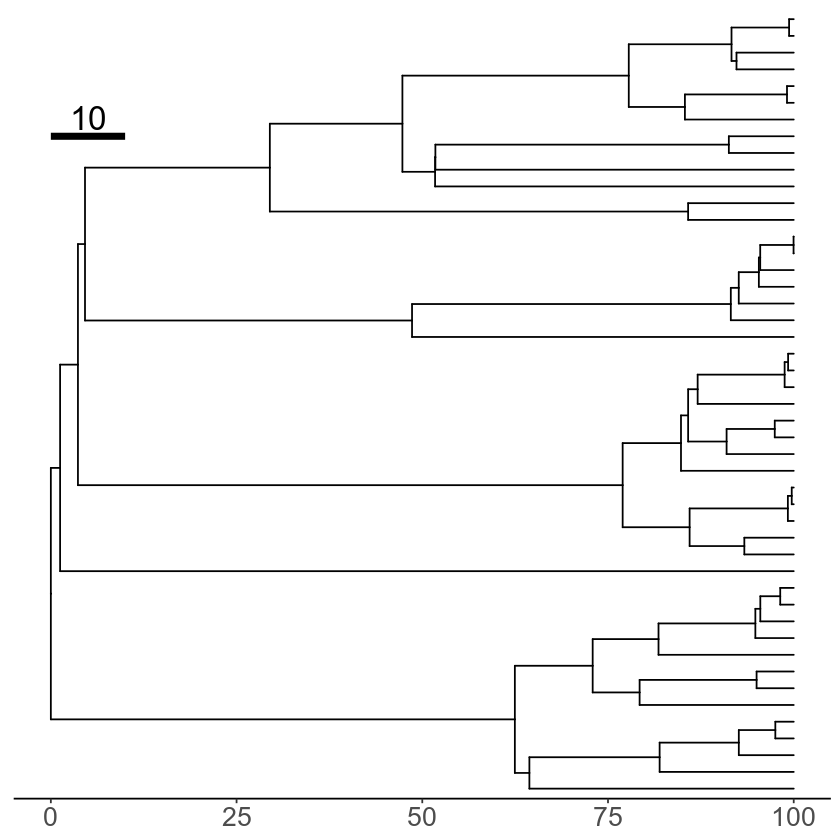

In [22]:
ggtree(sim_output$tes) + 
geom_treescale(x=0.0, y=40, width=10, fontsize=7, linesize = 2) +
theme_tree2(text = element_text(size = 20))

## Exercise 6
With the function L2phylo in the DDD package, we can convert the Ltable into a phylogeny that we can plot. Plot phylogenies and LTT-plots for the model described in exercise 5. What do you observe when λ1 >> λ0?

In [25]:
la_A <- c(2.0, 2.0)
la_B <- c(1.0, 10.0)
trait_rates <- c(0.5, 0.5)
mu <- 0.1
K <- 40
pars <- c(mu, K)

sim_output_A <- dd_sim_traits(la_A, trait_rates, pars, age=100)
sim_output_B <- dd_sim_traits(la_B, trait_rates, pars, age=100)

ltt_A <- as.data.frame(ape::ltt.plot.coords(sim_output_A$tes)) # just look at extant species, extincted species are excluded
ltt_B <- as.data.frame(ape::ltt.plot.coords(sim_output_B$tes))

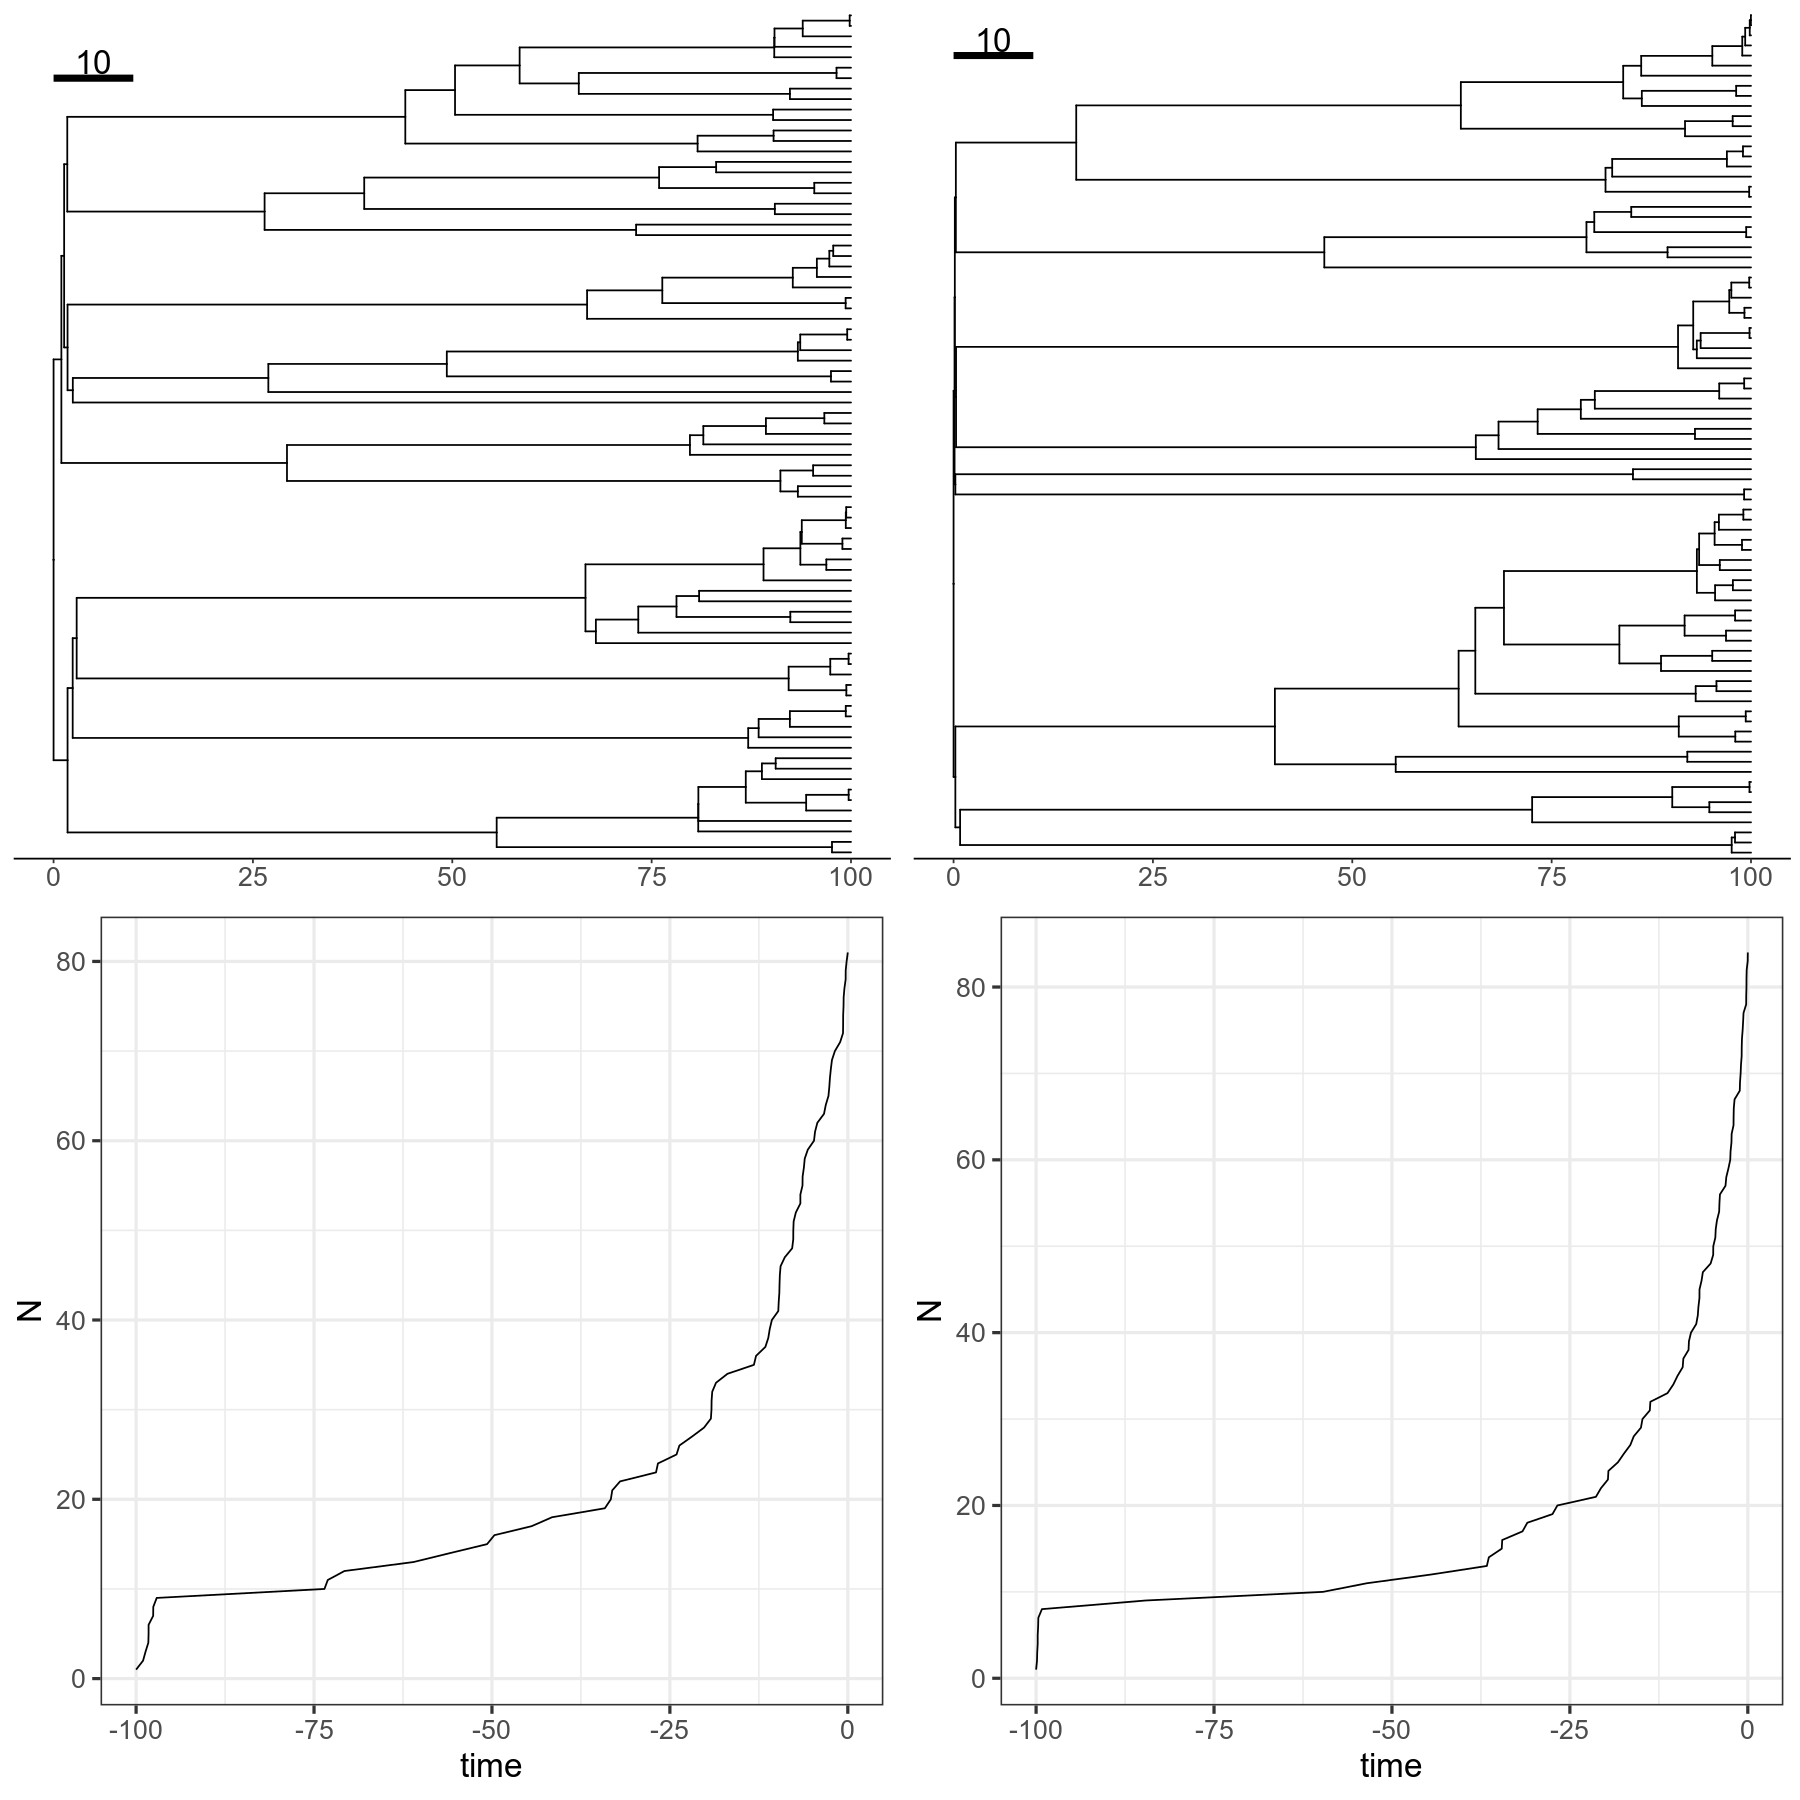

In [28]:
ptA <- ggtree(sim_output_A$tes) + 
        geom_treescale(x=0.0, y=75, width=10, fontsize=7, linesize = 2) +
        theme_tree2(text = element_text(size = 20))

ptB <- ggtree(sim_output_B$tes) + 
        geom_treescale(x=0.0, y=80, width=10, fontsize=7, linesize = 2) +
        theme_tree2(text = element_text(size = 20))

plA <- ggplot(ltt_A, aes(x=time, y=N)) + geom_line() +
        theme_bw(base_size = 20)

plB <- ggplot(ltt_B, aes(x=time, y=N)) + geom_line() +
        theme_bw(base_size = 20)

fig(15, 15)
grid.arrange(ptA, ptB, plA, plB, ncol=2, nrow=2)